# Clinical Trial Optimization 

Je presente ici ma solution pour le probléme d'opimisation d'un trie de sujet pour un test clinique.

### Presentation du probléme

Cette compétition organisée par Ingenii portait sur l'optimisation du tri des sujets pour un essai clinique. La description complète du problème est disponible sur [la plateforme Aqora](https://aqora.io/competitions/ingenii-clinical-trial), qui héberge la compétition.

Le problème consiste à regrouper les sujets en fonction de certains paramètres lors d'un essai clinique. L'objectif est qu'à l'issue de la formation des groupes, les sujets d'un même groupe soient adaptés aux tests cliniques qu'ils devront subir.

### Formulation mathématique

Nous avons 100 sujets que nous souhaitons répartir en deux groupes $p = \{1, 2\}$ de 50 personnes chacun. Chaque sujet $i$ est caractérisé par 3 paramètres $\vec{w_i} = (w_{i1}, w_{i2}, w_{i3})$. Nous mesurons la qualité de ce partitionnement à l'aide de la grandeur suivante :

$$
d = \sum_{s=1}^{3} |\Delta\mu_s| + \rho \sum_{s=1}^{3} |\Delta\sigma_{ss}| + 2\rho \sum_{s=1}^{3} \sum_{s' = s+1}^{3} |\Delta\sigma_{ss'}|
$$

où :

$$
\Delta\mu_s = \frac{1}{n} \sum_{i=1}^{n} w_{is}(x_{i1} - x_{i2})
$$

et :

$$
\Delta\sigma_{ss'} = \frac{1}{n} \sum_{i=1}^{n} w_{is} w_{is'} (x_{i1} - x_{i2})
$$

$x_{ip}$ est une variable binaire qui vaut 1 si le sujet $i$ appartient au groupe $p$, et 0 sinon.

La grandeur $d$ est appelée la *discrepancy*. Pour un regroupement idéal, la *discrepancy* est minimale. Ce problème de regroupement se ramène donc à résoudre le problème d'optimisation suivant :

$$
\min_{x} d
$$

sous les contraintes :

$$
\sum_{i}x_{ip} = \frac{n}{2}, \quad \text{Chaque groupe contient le même nombre de sujets.}
$$

$$
x_{i1} + x_{i2} = 1, \quad \text{Un sujet ne peut appartenir qu'à un seul groupe après le regroupement.}
$$

$$
x_{12} = 0, \quad \text{Ceci pour éviter la redondance des solutions, car on obtient le même regroupement en intervertissant les groupes 1 et 2.}
$$


Pour resourdre ce probléme j'utilise l'algorithme QAOA. qui permet de trouver la minimun ou le maximun d'une fonction quandratique. Alors le prmeier porbléme qu'on rencontre est que on ne peut pas directement implémenter $d$ à cause de la valeur absolue. DOnc nous alons d'abord reformuler le probléme pour qu'il puisse être implémenter avec l'algorithme QAOA

### Reformulation du problème

* **Écriture sans valeurs absolues :**
$$ a = |x| \Rightarrow x \leq a \text{ et } -x \leq a$$

Nous posons alors $z_s = |\Delta\mu_s|$, $z_{ss} = |\Delta\sigma_{ss}|$, et $z_{ss'} = |\Delta\sigma_{ss'}|$. La nouvelle formulation devient :
$$
\min_{x, z} \sum_{s=1}^{3} z_s + \rho \sum_{s=1}^{3} z_{ss} + 2\rho \sum_{s=1}^{3} \sum_{s' = s+1}^{3} z_{ss'}
$$
sous les contraintes suivantes :
$$
\sum_{i} x_{ip} = \frac{n}{2}, \quad \text{chaque groupe contient le même nombre de sujets.}
$$
$$
x_{i1} + x_{i2} = 1, \quad \text{un sujet ne peut appartenir qu'à un seul groupe après le regroupement.}
$$
$$
x_{12} = 0, \quad \text{cela évite la redondance des solutions, car intervertir les groupes 1 et 2 donnerait le même regroupement.}
$$
$$
\Delta\mu_s \leq z_s \text{ et } -\Delta\mu_s \leq z_s
$$
$$
\Delta\sigma_{ss} \leq z_{ss} \text{ et } -\Delta\sigma_{ss} \leq z_{ss}
$$
$$
\Delta\sigma_{ss'} \leq z_{ss'} \text{ et } -\Delta\sigma_{ss'} \leq z_{ss'}
$$

* **Réduction du nombre de variables :**

En remplaçant la contrainte $x_{i1} + x_{i2} = 1$ dans le problème, nous réduisons de $n$ le nombre de variables. En ajoutant les variables $z$, nous obtenons finalement $n - 1 + 9$, soit $n + 8$ variables.

## Implémentation
À ce stade, le problème est bien défini pour être implémenté avec l'algorithme QAOA. La prochaine étape consiste à le transformer en un problème QUBO.

In [414]:
n =   6 #number of subjects
N = 1 # on enléve la division par 1 dans la fonction objective
rho = 0.5

In [415]:
# importation of data of each subject
import csv
import numpy as np

data_list_csv = []
with open('pbc.csv', mode='r') as file:
    reader = csv.reader(file)
    # Skip the header
    next(reader)
    # Iterate over the rows and add them to the list
    for row in reader:
        # Convert strings to float for numeric columns
        data_list_csv.append([float(row[0]), float(row[1]), float(row[2])])

max_values = np.max(data_list_csv , axis=0)
data_list_frmt = data_list_csv

In [416]:
print(data_list_frmt[:10])

[[12.2, 58.7652292950034, 1718.0], [10.6, 56.4462696783025, 7394.8], [12.0, 70.072553045859, 516.0], [10.3, 54.7405886379192, 6121.8], [10.9, 38.1054072553046, 671.0], [11.0, 66.258726899384, 944.0], [9.7, 55.5345653661875, 824.0], [11.0, 53.056810403833, 4651.2], [11.0, 42.507871321013, 2276.0], [11.5, 70.5598904859685, 918.0]]


In [417]:
#creation of quadratic problem
from qiskit_optimization import QuadraticProgram
mod = QuadraticProgram("Clinical trial Optimization")

for i in range(1 , n + 1):
    var_name = f"x_{i}1"
    mod.binary_var(name=var_name)

# Integer varaibles  
W = []
for i in range(3):
    w_list = [row[i] for row in data_list_frmt]
    w_sum = 0
    for w in w_list:
        w_sum = w_sum + w # Sum of w
    W.append(w_sum)

mod.integer_var(name= "z_1" , lowerbound=0 , upperbound= int(W[0]) + 1)
mod.integer_var(name= "z_2" , lowerbound=0 , upperbound= int(W[1]) + 1)
mod.integer_var(name= "z_3" , lowerbound=0 , upperbound= int(W[2]) + 1)


W_square = []
for i in range(3):
    w_list = [row[i] for row in data_list_frmt]
    w_sum = 0
    for w in w_list:
        w_sum = w_sum + w**2 # sum of w square
    W_square.append(w_sum)

mod.integer_var(name= "z_11" , lowerbound=0 , upperbound= int(W_square[0]) + 1)
mod.integer_var(name= "z_22" , lowerbound=0 , upperbound= int(W_square[1]) + 1)
mod.integer_var(name= "z_33" , lowerbound=0 , upperbound= int(W_square[2]) + 1)


W_cross = []
for i in range(3):
    w_list_s = [row[i] for row in data_list_frmt]
    for k in range(i + 1, 3):
        w_sum = 0
        w_list_s_prime = [row[k] for row in data_list_frmt]
        for w_i, w_k in zip(w_list_s, w_list_s_prime):  
            w_sum = w_sum + w_i * w_k # sum of cross product
        W_cross.append(w_sum)
mod.integer_var(name = "z_12" , lowerbound=0 , upperbound=int(W_cross[0] + 1))
mod.integer_var(name = "z_13" , lowerbound=0 , upperbound=int(W_cross[1] + 1))
mod.integer_var(name = "z_23" , lowerbound=0 , upperbound=int(W_cross[2] + 1))

<Variable: 0 <= z_23 <= 30608403 (integer)>

In [418]:
# definition of the objective function
mod.minimize(linear={"z_1": 1 ,"z_2": 1 , "z_3": 1 
                      , "z_11":0.5 , "z_22":0.5 , "z_33":0.5
                      , "z_12":1 , "z_13":1 , "z_23":1})

## The constraints
Now we implément the constraints unders objective function we have 

In [419]:
# somme of x_i1 should be equal to n/2
dict_som = {f"x_{i}1": 1 for i in range(1 , n + 1)}
mod.linear_constraint(dict_som , sense= "==" , rhs = n/2 , name = "repartition egale")

#x_11 = 1
mod.linear_constraint({"x_11": 1} , sense= "==" , rhs = 1 , name= "avoid redundance")

<LinearConstraint: x_11 == 1 'avoid redundance'>

Contrainte: $\Delta\mu_s \leq z_s \text{ et } -\Delta\mu_s \leq z_s$

$$
\Delta\mu_s \leq z_s  \Rightarrow \sum_{i = 1}^{n}2w_{is}x_{i1} - nz_{s} \leq \sum_{i = 1}^{n}w_{is} \\

-\Delta\mu_s \leq z_s \Rightarrow \sum_{i = 1}^{n}2w_{is}x_{i1} + nz_{s} \geq \sum_{i = 1}^{n}w_{is} 
$$



In [420]:
for i in range(3):
    dict_x_s = {}
    w_list = [row[i] for row in data_list_frmt]

    # multipli toute l'équation par 100 pour avoir uniquement des coéfficients entiers
    dict_x_s = {f"x_{j + 1}1": int(round(2*w_list[j] , 2)*100)  for j in range(0 , n)} 
    dict_x_s.update({f"z_{i + 1}": -n * 100})
    mod.linear_constraint(linear=dict_x_s , sense= "<=" , rhs= int(round(W[i] , 2)*100))
    

for i in range(3):
    dict_x_s = {}
    w_list = [row[i] for row in data_list_frmt]
    dict_x_s = {f"x_{j + 1}1": int(round(2*w_list[j])*100)  for j in range(0 , n)}
    dict_x_s.update({f"z_{i + 1}": n*100})
    mod.linear_constraint(linear=dict_x_s , sense= ">=" , rhs= int(round(W[i] , 2)*100))
    

Contrainte: $\Delta\sigma_{ss} \leq z_{ss} \text{ et } -\Delta\sigma_{ss} \leq z_{ss}$

$$
\Delta\sigma_{ss} \leq z_{ss} \Rightarrow \sum_{i = 1}^{n}2w_{is}^2x_{i1} - nz_{ss}  \leq \sum_{i = 1}^{n}w_{is}^2 \\

- \Delta\sigma_{ss} \leq z_{ss} \Rightarrow \sum_{i = 1}^{n}2w_{is}^2x_{i1} + nz_{ss}  \geq \sum_{i = 1}^{n}w_{is}^2 
$$

In [421]:
for i in range(3):
    dict_x_s = {}
    w_list = [row[i] for row in data_list_frmt]
    dict_x_s = {f"x_{j + 1}1": int(round(2*(w_list[j]**2),2)*100) for j in range(0 , n)}
    dict_x_s.update({f"z_{i + 1}" + f"{i + 1}": -n*100})
    mod.linear_constraint(linear=dict_x_s , sense= "<=" , rhs= int(round(W_square[i],2)*100))
   


for i in range(3):
    dict_x_s = {}
    w_list = [row[i] for row in data_list_frmt]
    dict_x_s = {f"x_{j + 1}1": int(round(2*(w_list[j]**2),2)*100) for j in range(0 , n)}
    dict_x_s.update({f"z_{i + 1}" + f"{i + 1}": n*100})
    mod.linear_constraint(linear=dict_x_s , sense= ">=" , rhs= int(round(W_square[i] , 2)*100))
    

Containte: $\Delta\sigma_{ss'} \leq z_{ss'} \text{ et } -\Delta\sigma_{ss'} \leq z_{ss'}$

$$
\Delta\sigma_{ss'} \leq z_{ss'} \Rightarrow \sum_{i = 1}^{n}2w_{is}w_{is'}x_{i1} - nz_{ss'}  \leq \sum_{i = 1}^{n}w_{is}w_{is'} \\

- \Delta\sigma_{ss'} \leq z_{ss'} \Rightarrow \sum_{i = 1}^{n}2w_{is}w_{is'}x_{i1} + nz_{ss'}  \geq \sum_{i = 1}^{n}w_{is}w_{is'} 
$$

In [422]:
for i in range(3):
    w_list_s = [row[i] for row in data_list_frmt]
    for k in range(i + 1 , 3):
        dict_x_s = {}
        w_list_s_prime = [row[k] for row in data_list_frmt]
        dict_x_s = {f"x_{j + 1}1": int(round(2*(w_list_s[j]*w_list_s_prime[j]) , 2)*100) for j in range(0 , n)}
        dict_x_s.update({f"z_{i + 1}" + f"{k + 1}": -n*100})
        mod.linear_constraint(linear=dict_x_s , sense= "<=" , rhs= int(round(W_cross[i] , 2)*100))
        


for i in range(3):
    w_list_s = [row[i] for row in data_list_frmt]
    for k in range(i + 1 , 3):
        dict_x_s = {}
        w_list_s_prime = [row[k] for row in data_list_frmt]
        dict_x_s = {f"x_{j + 1}1": int(round(2*(w_list_s[j]*w_list_s_prime[j]) , 2)*100) for j in range(0 , n)}
        dict_x_s.update({f"z_{i + 1}" + f"{k + 1}": n*100})
        mod.linear_constraint(linear=dict_x_s , sense= ">=" , rhs= int(round(W_cross[i],2)*100))

In [423]:
print(mod.prettyprint())

Problem name: Clinical trial Optimization

Minimize
  z_1 + 0.5*z_11 + z_12 + z_13 + z_2 + 0.5*z_22 + z_23 + z_3 + 0.5*z_33

Subject to
  Linear constraints (20)
    x_11 + x_21 + x_31 + x_41 + x_51 + x_61 == 3  'repartition egale'
    x_11 == 1  'avoid redundance'
    2440*x_11 + 2120*x_21 + 2400*x_31 + 2060*x_41 + 2180*x_51 + 2200*x_61
    - 600*z_1 <= 334640  'c2'
    11753*x_11 + 11289*x_21 + 14015*x_31 + 10948*x_41 + 7620*x_51 + 13252*x_61
    - 600*z_2 <= 1560593  'c3'
    343600*x_11 + 1478960*x_21 + 103200*x_31 + 1224360*x_41 + 134200*x_51
    + 188800*x_61 - 600*z_3 <= 61858860  'c4'
    2400*x_11 + 2100*x_21 + 2400*x_31 + 2100*x_41 + 2200*x_51 + 2200*x_61
    + 600*z_1 >= 334640  'c5'
    11800*x_11 + 11300*x_21 + 14000*x_31 + 10900*x_41 + 7600*x_51 + 13300*x_61
    + 600*z_2 >= 1560593  'c6'
    343600*x_11 + 1479000*x_21 + 103200*x_31 + 1224400*x_41 + 134200*x_51
    + 188800*x_61 + 600*z_3 >= 61858860  'c7'
    29768*x_11 + 22472*x_21 + 28800*x_31 + 21218*x_41 + 23762*x_51

## Transformation en QUBO

Le probléme quantique avec les contraintes est bien defini. maintenant nous allons le transformer en probléme quadratique non constraint avec la méthode 'QuadraticprogramToQubo'

In [424]:
from qiskit_optimization.converters import QuadraticProgramToQubo

cto_qubo = QuadraticProgramToQubo().convert(mod)
print(cto_qubo.prettyprint())

Problem name: Clinical trial Optimization

Minimize
  1364145036.5*c10@int_slack@0^2 + 5456580146*c10@int_slack@0*c10@int_slack@1
  + 2793769034752.0*c10@int_slack@0*c10@int_slack@10
  + 5587538069504.0*c10@int_slack@0*c10@int_slack@11
  + 11175076139008.0*c10@int_slack@0*c10@int_slack@12
  + 22350152278016.0*c10@int_slack@0*c10@int_slack@13
  + 44700304556032.0*c10@int_slack@0*c10@int_slack@14
  + 89400609112064.0*c10@int_slack@0*c10@int_slack@15
  + 178801218224128.0*c10@int_slack@0*c10@int_slack@16
  + 357602436448256.0*c10@int_slack@0*c10@int_slack@17
  + 715204872896512.0*c10@int_slack@0*c10@int_slack@18
  + 1430409745793024.0*c10@int_slack@0*c10@int_slack@19
  + 10913160292.0*c10@int_slack@0*c10@int_slack@2
  + 2860819491586048.0*c10@int_slack@0*c10@int_slack@20
  + 5721638983172096.0*c10@int_slack@0*c10@int_slack@21
  + 1.1443277966344192e+16*c10@int_slack@0*c10@int_slack@22
  + 2.2886555932688384e+16*c10@int_slack@0*c10@int_slack@23
  + 4.577311186537677e+16*c10@int_slack@0*c10

### Mapping into Ising Problem

Lorsqu'on transforme un problème quadratique en QUBO (Quadratic Unconstrained Binary Optimization), on se rend compte du nombre exponentiellement élevé de variables binaires supplémentaires nécessaires pour cette conversion. Cela est dû aux contraintes d'inégalité. En effet, pour une contrainte du type $a_0x_0 + ... + a_nx_n \leq S$, il faut $\log_{2}(S) + 1$ variables binaires supplémentaire pour en faire une contraite sur l'égalité.

Dans notre cas, les seconds membres des contraintes d'inégalité sont au moins de l'ordre de $10^5$, ce qui nécessite au moins 18 variables supplémentaires par équation. Avec 18 équations, cela représente au moins 324 variables supplémentaires, ce qui rend le problème pratiquement incalculable.

Ainsi, en raison de la formulation en valeur absolue, des données mises en jeu dans ce problème, et des contraintes de formatage imposées par la librairie Qiskit, une approche directe pour résoudre ce problème devient inaccessible.

In [425]:
# hamiltonian , offset = cto_qubo.to_ising()
# print("Offset:", offset)
# print("Ising Hamiltonian:")
# print(str(qubitOp))

Nous allons essayer une autre approche. au lieu de trouver le minimun de d , nous allons chercher le minimun de 
$$
d' = \sum_{s=1}^{3} (\Delta\mu_s)^2 + \rho \sum_{s=1}^{3} (\Delta\sigma_{ss})^2 + 2\rho \sum_{s=1}^{3} \sum_{s' = s+1}^{3} (\Delta\sigma_{ss'})^2
$$

ceci sous les mêmes contrainte que $d$. Je travaille avec d' dans l'hypothése que d et d' atteignent leur minimum pour le même x ou du moins pour des x proches.
On voit sur les exemples ci dessous que d et d' atteignent bien leur minimun pour la même chaine de bit

In [426]:
def objective_func_square(x_list  , n):
    d_prime = 0
    d_1 =0
    d_2 = 0
    d_3 = 0
    for s in range(3):
        w = 0
        for i in range(n):
            w = w + data_list_frmt[i][s]*(2*x_list[i] - 1)
        w = (w/n)**2
        d_1 = d_1 + w

    for s in range(3):
        w = 0
        for i in range(n):
            w = w + (data_list_frmt[i][s]**2)*(2*x_list[i] - 1)
        w = (w/n)**2
        d_2 = d_2 + w
    d_2 = rho*d_2

    for s in range(3):
        for s_p in range(s , 3):
            w = 0
            for i in range(n):
                w = w + (data_list_frmt[i][s]*data_list_frmt[i][s_p])*(2*x_list[i] - 1)
            w = (w/n)**2
            d_3 = d_3 + w
    d_3 = 2*rho*d_2

    d_prime = d_1 + d_2 + d_3
    return d_prime
    

def objective_func(x_list  , n):
    d = 0
    d_1 =0
    d_2 = 0
    d_3 = 0
    for s in range(3):
        w = 0
        for i in range(n):
            w = w + data_list_frmt[i][s]*(2*x_list[i] - 1)
        w = np.abs(w/n)
        d_1 = d_1 + w

    for s in range(3):
        w = 0
        for i in range(n):
            w = w + (data_list_frmt[i][s]**2)*(2*x_list[i] - 1)
        w = np.abs(w/n)
        d_2 = d_2 + w
    d_2 = rho*d_2

    for s in range(3):
        for s_p in range(s , 3):
            w = 0
            for i in range(n):
                w = w + (data_list_frmt[i][s]*data_list_frmt[i][s_p])*(2*x_list[i] - 1)
            w = np.abs(w/n)
            d_3 = d_3 + w
    d_3 = 2*rho*d_2

    d = d_1 + d_3 + d_3
    return d



import itertools
list_test = [2, 4, 6, 10, 12, 14, 16, 18]

# Boucle sur différentes valeurs de M
for M in list_test:
    poss_list = list(itertools.product([0, 1], repeat=M))  # Liste de toutes les combinaisons binaires
    d_min = 1e20  # Initialisation de la valeur minimale de la première fonction
    d_min_square = 1e20  # Initialisation de la valeur minimale de la seconde fonction
    best_x = None  # Pour stocker la meilleure solution de la première fonction
    best_x_square = None  # Pour stocker la meilleure solution de la seconde fonction

    # Boucle sur toutes les combinaisons binaires possibles
    for x in poss_list:
        if sum(x) == M / 2:  # Condition sur la somme des éléments de x
            if x[0] == 1:  # Condition sur le premier élément de x
                # Calcul des valeurs des fonctions
                d = objective_func(x, M)
                d_square = objective_func_square(x, M)

                # Mise à jour de la meilleure valeur pour la première fonction
                if d < d_min:
                    d_min = d
                    best_x = x

                # Mise à jour de la meilleure valeur pour la seconde fonction
                if d_square < d_min_square:
                    d_min_square = d_square
                    best_x_square = x

    # Affichage des résultats
    print(f"M = {M}:")
    print(f"Minimum value (func1, func2): ({d_min}, {d_min_square})")
    print(f"Best x (func1, func2): ({best_x}, {best_x_square})")
    print("-" * 50)

    

M = 2:
Minimum value (func1, func2): (25868763.704886556, 669038144399537.5)
Best x (func1, func2): ((1, 0), (1, 0))
--------------------------------------------------
M = 4:
Minimum value (func1, func2): (3630773.9507093076, 13179375582999.545)
Best x (func1, func2): ((1, 0, 0, 1), (1, 0, 0, 1))
--------------------------------------------------
M = 6:
Minimum value (func1, func2): (2346996.4062184403, 5507211203816.434)
Best x (func1, func2): ((1, 0, 0, 1, 0, 1), (1, 0, 0, 1, 0, 1))
--------------------------------------------------
M = 10:
Minimum value (func1, func2): (50525.60581048776, 2520478540.747118)
Best x (func1, func2): ((1, 0, 1, 1, 1, 0, 0, 1, 0, 0), (1, 0, 1, 1, 1, 0, 0, 1, 0, 0))
--------------------------------------------------
M = 12:
Minimum value (func1, func2): (7768.342184312127, 56255086.06204513)
Best x (func1, func2): ((1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1), (1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1))
--------------------------------------------------
M = 14:
Minimum

Pour implémenter cette nouvelle fonction quadratique $d'$, on doit calculer les coéficients des termes linéaires $x_{i1}$ et des termes qudratiques $x_{i1}x_{j1}$

$$
(\Delta\mu_s)^2 = \frac{1}{n^2} \left( \sum_{j = 1}^{n}\sum_{i = 1}^{n} w_{js}w_{is}(4x_{j1}x_{i1} - 2x_{j1} - 2x_{i1} + 1) \right) = \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{is}x_{j1}x_{i1} - \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{is}x_{i1} + \frac{1}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{is}
$$

$$
(\Delta\sigma_{ss})^{2} = \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}^2w_{is}^2x_{j1}x_{i1} - \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}^2w_{is}^2x_{i1} + \frac{1}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}^2w_{is}^2
$$

$$
(\Delta\sigma_{ss'})^{2} = \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{js'}w_{is}w_{is'}x_{j1}x_{i1} - \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{js'}w_{is}w_{is'}x_{i1} + \frac{1}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{js'}w_{is}w_{is'}
$$


In [427]:
variable_name = [f"x_{i + 1}1" for i in range(n)]
mod_square = QuadraticProgram("Clinical trial Optimization")

for i in range(1 , n + 1):
    var_name = f"x_{i}1"
    mod_square.binary_var(name=var_name)

#DELTA MU_s contribution
#terme quadratique
coef_quad_1 = [] # liste des coéffcients du terme quadratique de delta mu
dict_quad_1 = {} # dictionaire des termes quadratique et de leurs valeurs
for i in range(n):
    for j in range(n):
            l = 0
            for s in range(3):
                 l = l + data_list_frmt[i][s]*data_list_frmt[j][s]
            coef_quad_1.append(l)

coef_quad_1 = [ coef*(4/(n*n)) for coef in coef_quad_1]

dict_quad_1 = { (variable_name[i], variable_name[j]): None 
                 for i in range(n) for j in range(n)}
dict_quad_1 = {cle: coef_quad_1[i] for i, cle in enumerate(dict_quad_1.keys())}

#terme linéaire
coef_lin_1 = [] # liste des coefficients linéaire de delta mu
dict_lin_1 = {} # dictionaire des terme linéaire de delta mu et de leurs coefficient
for i in range(n):
    sub_sum_2 = 0
    for s in range(3):
        sub_sum = 0
        for j in range(n):
            sub_sum = sub_sum + data_list_frmt[j][s]

        sub_sum_2 = sub_sum_2 + sub_sum*data_list_frmt[i][s]

    coef_lin_1.append(sub_sum_2)
coef_lin_1 = [coef*(-4/(n**2)) for coef in coef_lin_1]    

dict_lin_1 = {variable_name[i]: coef_lin_1[i] for i in range(len(variable_name))}

coef_const_1 = [] # liste des constantes de delta mu 
const_1 = 0 # somme des contantes de delta mu
coef_const_1 = [coef*(1/4) for coef in coef_quad_1] 
const_1 = sum(coef_const_1)


#(SIGMA_ss)^2 contribution
#quadratic term
coef_quad_2 = [] # liste des coéffcients du terme quadratique de sigma_ss
dict_quad_2 = {} # dictionaire des termes quadratique de de sigma_ss et de leurs valeurs 
for i in range(n):
    for j in range(n):
            l = 0
            for s in range(3):
                 l = l + rho*(data_list_frmt[i][s]**2)*(data_list_frmt[j][s]**2)
            coef_quad_2.append(l)

coef_quad_2 = [ coef*(4/(n*n)) for coef in coef_quad_1]

dict_quad_2 = { (variable_name[i], variable_name[j]): None 
                 for i in range(n) for j in range(n)}
dict_quad_2 = {cle: coef_quad_2[i] for i, cle in enumerate(dict_quad_2.keys())}

#linear terms
coef_lin_2 = [] # liste des coefficients linéaire de sigma_ss
dict_lin_2 = {} # dictionaire des termes linéaires de sigam_ss et de leurs coefficient
for i in range(n):
    for s in range(3):
        sub_sum = 0
        sub_sum_2 = 0
        for j in range(n):
            sub_sum = sub_sum + rho*(data_list_frmt[j][s]**2)

        sub_sum = sub_sum*(data_list_frmt[i][s]**2)
        sub_sum_2 = sub_sum_2 + sub_sum
    coef_lin_2.append(sub_sum_2)
coef_lin_2 = [coef*(-4/(n**2)) for coef in coef_lin_2]    

dict_lin_2 = {variable_name[i]: coef_lin_2[i] for i in range(len(variable_name))}

#terme constant
coef_const_2 = [] # liste des constantes de sigma_ss 
const_2 = 0 # somme des contantes de sigma_ss
coef_const_2 = [coef*(1/4) for coef in coef_quad_2] 
const_2 = sum(coef_const_2)



#(SIGMA_ss')^2 contribution
# termes quadratic
coef_quad_3 = [] # liste des coéffcients du terme quadratique de sigma_ss
dict_quad_3 = {} # dictionaire des termes quadratique de de sigma_ss et de leurs valeurs 
for i in range(n):
    for j in range(n):
            l = 0
            for s in range(3):
                 for s_p in range(s , 3):
                    l = l + 2*rho*(data_list_frmt[i][s]*data_list_frmt[i][s_p])*(data_list_frmt[j][s]*data_list_frmt[j][s_p])
            coef_quad_3.append(l)

coef_quad_3 = [ coef*(4/(n*n)) for coef in coef_quad_3]

dict_quad_3 = { (variable_name[i], variable_name[j]): None 
                 for i in range(n) for j in range(n)}
dict_quad_3 = {cle: coef_quad_3[i] for i, cle in enumerate(dict_quad_3.keys())}


#Termes linéaire
coef_lin_3 = [] # liste des coefficients linéaire de sigma_ss'
dict_lin_3 = {} # dictionaire des termes linéaires de sigam_ss' et de leurs coefficient
for i in range(n):
    for s in range(3):
        for s_p in range(s , 3):
            sub_sum = 0
            sub_sum_2 = 0
            for j in range(n):
                sub_sum = sub_sum + (data_list_frmt[j][s]*data_list_frmt[j][s_p])

            sub_sum = 2*rho* sub_sum*(data_list_frmt[i][s]*data_list_frmt[i][s_p])
            sub_sum_2 = sub_sum_2 + sub_sum
    coef_lin_3.append(sub_sum_2)
coef_lin_3 = [coef*(-4/(n**2)) for coef in coef_lin_3]    

dict_lin_3 = {variable_name[i]: coef_lin_3[i] for i in range(len(variable_name))}

#terme constant
coef_const_3 = [] # liste des constantes de sigma_ss' 
const_3 = 0 # somme des contantes de sigma_ss'
coef_const_3 = [coef*(1/4) for coef in coef_quad_3] 
const_3 = sum(coef_const_3)




# Sommation des coéfficients lineaire de chaque terme delta , sigma_ss et sigma_ss'
lin_dict = [dict_lin_1 , dict_lin_2 , dict_lin_3]
lin = {}
for d in lin_dict:
    for key , value in d.items():
        lin[key] = lin.get(key,0) + (value/1e15)

# Sommation des coéfficients quadratique
lin_quad = [dict_quad_1 , dict_quad_2 , dict_quad_3]
quad = {}
for d in lin_quad:
    for key , value in d.items():
        quad[key] = quad.get(key,0) + (value/1e15)

#sommation des constantes:
C = (const_1 + const_2 + const_3)/(1e15)

In [428]:
# definition of the quadratic problem
mod_square.minimize(constant= C , linear= lin , quadratic= quad)

In [429]:
# adding constrainte
dict_som = {f"x_{i}1": 1 for i in range(1 , n + 1)}
mod_square.linear_constraint(dict_som , sense= "==" , rhs = n/2 , name = "repartition egale") # somme des x_i = n/2
mod_square.linear_constraint({"x_11": 1} , sense= "==" , rhs = 1 , name= "avoid redundance") # x_11 = 1


<LinearConstraint: x_11 == 1 'avoid redundance'>

In [430]:
print(mod_square.prettyprint())

Problem name: Clinical trial Optimization

Minimize
  0.0009691268471661688*x_11^2 + 0.035876043175246446*x_11*x_21
  + 0.00017547994068538997*x_11*x_31 + 0.024588394322935567*x_11*x_41
  + 0.0002959196470339548*x_11*x_51 + 0.0005859464956207575*x_11*x_61
  + 0.3322686962827216*x_21^2 + 0.0032389539778721523*x_21*x_31
  + 0.4554380670333438*x_21*x_41 + 0.0054737366898791355*x_21*x_51
  + 0.01083488754809299*x_21*x_61 + 8.029233070010591e-06*x_31^2
  + 0.002220189254380331*x_31*x_41 + 2.6857119756129306e-05*x_31*x_51
  + 5.324864934655502e-05*x_31*x_61 + 0.15606661382936982*x_41^2
  + 0.0037516591951884653*x_41*x_51 + 0.007426274656766322*x_41*x_61
  + 2.2603000899026832e-05*x_51^2 + 8.953524194638745e-05*x_51*x_61
  + 8.868492167733532e-05*x_61^2 - 0.04757791066936337*x_11
  - 0.8814788358417807*x_21 - 0.004291988222607702*x_31
  - 0.6041117736486767*x_41 - 0.007257785608388967*x_51
  - 0.014364915016766141*x_61 + 0.25987473676574957

Subject to
  Linear constraints (2)
    x_11 + x_21

### Transformation to QUBO problem

In [431]:
cto_square_qubo = QuadraticProgramToQubo().convert(mod_square)
print(cto_square_qubo.prettyprint())

Problem name: Clinical trial Optimization

Minimize
  7.19813343898833*x_11^2 + 7.23304035531641*x_11*x_21
  + 7.1973397920818485*x_11*x_31 + 7.221752706464099*x_11*x_41
  + 7.197460231788197*x_11*x_51 + 7.197750258636784*x_11*x_61
  + 3.9308508523533034*x_21^2 + 7.200403266119036*x_21*x_31
  + 7.652602379174508*x_21*x_41 + 7.202638048831043*x_21*x_51
  + 7.207999199689256*x_21*x_61 + 3.5985901853036517*x_31^2
  + 7.199384501395544*x_31*x_41 + 7.19719116926092*x_31*x_51
  + 7.19721756079051*x_31*x_61 + 3.7546487698999513*x_41^2
  + 7.200915971336352*x_41*x_51 + 7.20459058679793*x_41*x_61
  + 3.5986047590714807*x_51^2 + 7.197253847383109*x_51*x_61
  + 3.598670840992259*x_61^2 - 28.836235159234022*x_11 - 22.47297177226527*x_21
  - 21.5957849246461*x_31 - 22.195604710072168*x_41 - 21.59875072203188*x_51
  - 21.60585785144026*x_61 + 36.245696297471575

Subject to
  No constraints

  Binary variables (6)
    x_11 x_21 x_31 x_41 x_51 x_61



In [432]:
# Get Ising Hamiltonian
ising_hamiltonian , offset = cto_square_qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(ising_hamiltonian))

Offset: 7.059728119697599
Ising Hamiltonian:
SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZZIIII'],
              coeffs=[1.80721502e+00+0.j, 1.46889648e-01+0.j, 7.13297259e-04+0.j,
 1.00666434e-01+0.j, 1.20816433e-03+0.j, 2.39064190e-03+0.j,
 1.80826009e+00+0.j, 1.79933495e+00+0.j, 1.80543818e+00+0.j,
 1.79936506e+00+0.j, 1.79943756e+00+0.j, 1.80010082e+00+0.j,
 1.91315059e+00+0.j, 1.80065951e+00+0.j, 1.80199980e+00+0.j,
 1.79984613e+00+0.j, 1.79929779e+00+0.j, 1.79930439e+00+0.j,
 1.80022899e+00+0.j, 1.80114765e+00+0.j, 1.79931346e+00+0.j])


# Searching of ground state of Ising Hamiltonian
Cette partie du code inspiré du tutoriel [Solve utility-scale quantum optimization problems](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm) et se deroule suivant les étapes suivantes:

* creation d'un circuit paramétré à partir de l'hamiltonien du probléme avec QAOAAnsatz()
* Conversion de ce circuit en un circuit adapté à l'ordinateur sur le quel il doit tourner grace au pass manager
* optimisation des paramétres de ce circuit 
* Execution du circuit avec les paramétres optimisé sur l'ordinateur quantique.

Je n'ai pas exactement executer travailler sur un ordinateur quantique à cause des limites de temps d'acces mais un  simulateur qui simule le comportement d'un ordinateur quantique. 

In [433]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli

# Définir un mixer XY pour un système avec plusieurs qubits
def xy_mixer_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    for i in range(0, num_qubits - 1, 1):  # Appliquer sur des paires de qubits (0-1, 2-3, ...)
        # Pauli-X sur les qubits en interaction
        qc.cx(i, i + 1)  # Applique une porte CNOT entre les deux qubits
        qc.ry(0.5, i + 1)  # Rotation autour de Y sur le qubit cible
        qc.cx(i, i + 1)  # Appliquer de nouveau une CNOT pour créer une interaction XY
    return qc

# Créer un circuit de mixage XY pour 4 qubits
mixer_circuit = xy_mixer_circuit(10)
#mixer_circuit.draw('mpl')

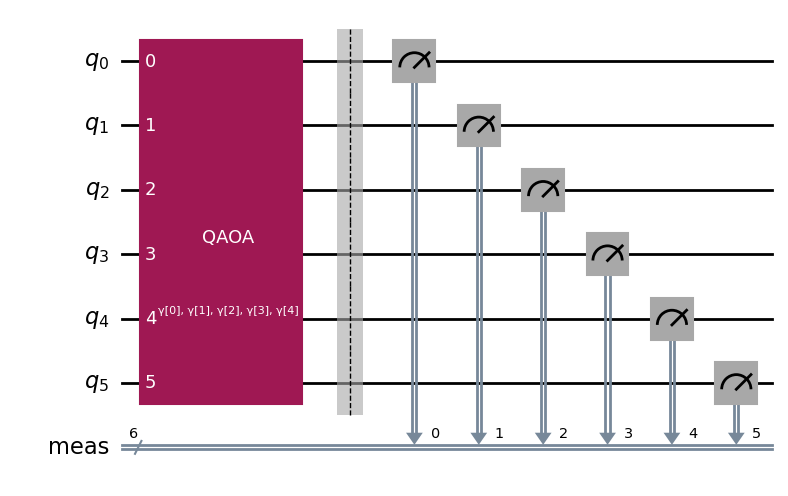

In [434]:
from qiskit.circuit.library import QAOAAnsatz

#circuit = QAOAAnsatz(cost_operator= ising_hamiltonian , reps=2 , mixer_operator= xy_mixer_circuit(n))
#circuit = QAOAAnsatz(cost_operator= ising_hamiltonian , reps= 5 , mixer_operator= xy_mixer_circuit(n))
circuit = QAOAAnsatz(cost_operator= ising_hamiltonian , reps= 5 , mixer_operator= xy_mixer_circuit(n))
circuit.measure_all()

circuit.draw('mpl' , fold = False , scale = 1 , idle_wires = False)


In [435]:
circuit.depth()

2

In [436]:
circuit.parameters

ParameterView([ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2]), ParameterVectorElement(γ[3]), ParameterVectorElement(γ[4])])

In [437]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()
backend = service.backend("ibm_sherbrooke")
aer = AerSimulator.from_backend(backend)

#Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3 , backend=aer)
hardware_circuit = pm.run(circuit)
#hardware_circuit.draw('mpl' , fold = False , scale = 0.5 , idle_wires=False)

In [438]:
initial_gamma = np.pi
initial_beta = np.pi
init_params = [initial_gamma ,  initial_beta ,initial_gamma ,  initial_beta ,initial_gamma ]#,  initial_beta , initial_gamma ,  initial_beta ,initial_gamma ,  initial_beta  ]


In [439]:
len(init_params)

5

In [440]:
def cost_func_estimator(params , ansatz , hamiltonian ,  estimator):

    # transform the observable defined on virtual qubits to 
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz , isa_hamiltonian , params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

In [441]:
from qiskit_ibm_runtime import Session , EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable

with Session(backend=aer) as session:
    # If using qiskit-ibm-runtime<0.24.0 , change 'mode=' to 'session='
    estimator = Estimator(session= session)
    #estimator.options.default_shots = 1000

    # Set simple error suppresion / mitigation options
    # estimator.options.dynamical_decoupling.enable = True
    # estimator.options.dynamical_decoupling.sequence_type = "XY4"
    # estimator.options.twirling.enable_gates = True
    # estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator , 
        init_params,
        args = (hardware_circuit , ising_hamiltonian , estimator),
        method = "COBYLA",
        tol=1e-2
        
    )
    print(result)

c:\Users\isaac\anaconda3\envs\qiskit_env\Lib\site-packages\qiskit_ibm_runtime\session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.49386460337494237
       x: [ 4.146e+00  3.315e+00  2.961e+00  4.116e+00  3.244e+00]
    nfev: 31
   maxcv: 0.0


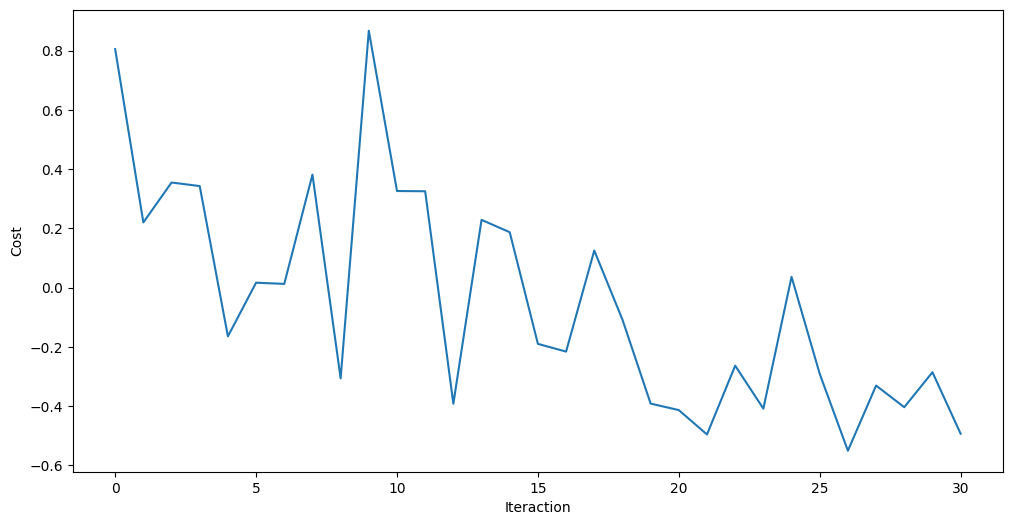

In [442]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(objective_func_vals)
plt.xlabel("Iteraction")
plt.ylabel("Cost")
plt.show()

In [443]:
optimized_circuit = hardware_circuit.assign_parameters(result.x)
#optimized_circuit.draw('mpl' , fold = False , idle_wires = False)

In [444]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend = aer)
sampler.options.default_shots = 10000

# Set simple error suppresion/mitigation options
# sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
# sampler.options.twirling.enable_gates  = True
# sampler.options.twirling.num_randomizations = "auto"

pub = (optimized_circuit , )
job = sampler.run([pub] , shots = int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()

shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{42: 0.0296, 35: 0.0143, 57: 0.0156, 60: 0.0149, 31: 0.0202, 56: 0.0183, 43: 0.0194, 19: 0.0169, 3: 0.0145, 21: 0.0261, 12: 0.015, 52: 0.0137, 20: 0.0255, 50: 0.0108, 39: 0.0134, 18: 0.0111, 27: 0.012, 46: 0.0157, 47: 0.0171, 29: 0.0176, 44: 0.0198, 41: 0.0169, 23: 0.0155, 14: 0.0135, 58: 0.0131, 16: 0.0167, 32: 0.009, 51: 0.0129, 11: 0.0138, 2: 0.0124, 26: 0.0151, 54: 0.0131, 15: 0.0157, 5: 0.0152, 30: 0.0172, 40: 0.0154, 6: 0.0127, 59: 0.0193, 38: 0.013, 17: 0.0145, 7: 0.0135, 45: 0.0329, 49: 0.0118, 25: 0.0141, 1: 0.0142, 33: 0.0154, 13: 0.018, 48: 0.0122, 22: 0.0163, 62: 0.0166, 8: 0.0128, 9: 0.0168, 53: 0.0134, 10: 0.0112, 36: 0.0155, 28: 0.0206, 63: 0.0151, 61: 0.0145, 34: 0.012, 24: 0.0116, 0: 0.0121, 55: 0.0113, 4: 0.014, 37: 0.0176}


In [445]:
# Trier par valeurs et récupérer les 3 plus grandes paires clé-valeur
top_5 = dict(sorted(final_distribution_bin.items(), key=lambda item: item[1], reverse=True)[:5])

print(top_5)

{'101101': 0.0329, '101010': 0.0296, '010101': 0.0261, '010100': 0.0255, '011100': 0.0206}


### Brute force test

In [446]:
def objective_func_square(x_list  , n):
    d_prime = 0
    d_1 =0
    d_2 = 0
    d_3 = 0
    for s in range(3):
        w = 0
        for i in range(n):
            w = w + data_list_frmt[i][s]*(2*x_list[i] - 1)
        w = (w/n)**2
        d_1 = d_1 + w

    for s in range(3):
        w = 0
        for i in range(n):
            w = w + (data_list_frmt[i][s]**2)*(2*x_list[i] - 1)
        w = (w/n)**2
        d_2 = d_2 + w
    d_2 = rho*d_2

    for s in range(3):
        for s_p in range(s , 3):
            w = 0
            for i in range(n):
                w = w + (data_list_frmt[i][s]*data_list_frmt[i][s_p])*(2*x_list[i] - 1)
            w = (w/n)**2
            d_3 = d_3 + w
    d_3 = 2*rho*d_2

    d_prime = d_1 + d_2 + d_3
    return (d_prime/1)
    

def objective_func(x_list  , n):
    d = 0
    d_1 =0
    d_2 = 0
    d_3 = 0
    for s in range(3):
        w = 0
        for i in range(n):
            w = w + data_list_frmt[i][s]*(2*x_list[i] - 1)
        w = np.abs(w/n)
        d_1 = d_1 + w

    for s in range(3):
        w = 0
        for i in range(n):
            w = w + (data_list_frmt[i][s]**2)*(2*x_list[i] - 1)
        w = np.abs(w/n)
        d_2 = d_2 + w
    d_2 = rho*d_2

    for s in range(3):
        for s_p in range(s , 3):
            w = 0
            for i in range(n):
                w = w + (data_list_frmt[i][s]*data_list_frmt[i][s_p])*(2*x_list[i] - 1)
            w = np.abs(w/n)
            d_3 = d_3 + w
    d_3 = 2*rho*d_2

    d = d_1 + d_3 + d_3
    return d
    

In [447]:
import itertools
list_test = [n]

# Boucle sur différentes valeurs de M
for M in list_test:
    poss_list = list(itertools.product([0, 1], repeat=M))  # Liste de toutes les combinaisons binaires
    d_min = 1e100  # Initialisation de la valeur minimale de la première fonction
    d_min_square = 1e100  # Initialisation de la valeur minimale de la seconde fonction
    best_x = None  # Pour stocker la meilleure solution de la première fonction
    best_x_square = None  # Pour stocker la meilleure solution de la seconde fonction

    # Boucle sur toutes les combinaisons binaires possibles
    for x in poss_list:
        if sum(x) == M / 2:  # Condition sur la somme des éléments de x
            if x[0] == 1:  # Condition sur le premier élément de x
                # Calcul des valeurs des fonctions
                d = objective_func(x, M)
                d_square = objective_func_square(x, M)

                # Mise à jour de la meilleure valeur pour la première fonction
                if d < d_min:
                    d_min = d
                    best_x = x

                # Mise à jour de la meilleure valeur pour la seconde fonction
                if d_square < d_min_square:
                    d_min_square = d_square
                    best_x_square = x

    # Affichage des résultats
    print(f"M = {M}:")
    print(f"Minimum value (func1, func2): ({d_min}, {d_min_square})")
    print(f"Best x (func1, func2): ({best_x}, {best_x_square})")
    print("-" * 50)


M = 6:
Minimum value (func1, func2): (2346996.4062184403, 5507211203816.434)
Best x (func1, func2): ((1, 0, 0, 1, 0, 1), (1, 0, 0, 1, 0, 1))
--------------------------------------------------


In [448]:
objective_func_square([1 , 0 , 0 , 1] , 4)

13179375582999.545

# Conclusion

The search for parameters to optimize the circuit running on the hardware is limited by the size of the problem. However, I believe that for $n = 100$, it is still feasible, as shown in the tutorial. It would just require a computer with more memory. That being said, I cannot solve the problem with $n = 100$ on my current PC. The highest value of $n$ I can run is 16.

It is also evident that the data plays a crucial role. In fact, in $d'$, when I work with the coefficients as they are, the optimization of the cost function does not converge because the numbers involved are very large, around $10^{14}$. By dividing the entire function by $10^{14}$ to reduce the coefficients, we observe that the function converges. However, the algorithm remains inefficient. This can be explained by the fact that, in our case, all qubits are connected to each other, with $2n$ products of the type $x_{i1}x_{j1}$. Thus, the problem seems ill-suited for solving with the QAOA algorithm. It would be interesting to explore a quantum annealing approach.
